In [91]:
library(here)
setwd(here())
print(getwd())
source(file="misc_functions.R")
source(file="experiments/learning_curve/learning_curve.R")
source(file="experiments/titanic_challenge/1_feature_engineering.R")

library(lattice)
library(gridExtra)
library(mice)
library(ggplot2)

library(randomForest)
library(e1071)

[1] "/home/sapristi/Documents/ML"


In [15]:
test.raw <- read.csv("datasets/titanic_na/test.csv")
train.raw <- read.csv("datasets/titanic_na/train.csv")

train.raw$SurvivedF <- as.factor(train.raw$Survived)
train.to_complete <- fe$forge_features_add(train.raw, more_tickets = test.raw$Ticket)

library(mice)
imp <-  mice(train.to_complete, m=5,  printFlag = FALSE, formulas = list(Age.simple = Age.simple ~ Title, Fare.log = Fare.log ~ Pclass))
train = complete(imp, 1)

train$Age <- NULL
train$Age.disc5 <- NULL
train$Fare <- NULL
train$Fare.sqrt <- NULL


In [16]:
make_learning_curves <- function(model_funs, predict_funs, train, test, target, features, steps, limit=NULL, title = NULL) {
    plot <- NULL
    for (model in names(model_funs)) {
        model_fun <- model_funs[[model]]
        predict_fun <- predict_funs[[model]]
        plot <- learning_curve$plot(train, test, target, features, model_fun, predict_fun, steps, title = model, previous_plot = plot, limit = limit)
    }
    plot <- learning_curve$make_decor(plot, title, ymin=0.5)
    return(plot)
}

In [17]:


svm.linear.model_fun  <- function(formula, train) {
  return(svm(as.formula(formula), 
             data = train, kernel="linear", cost=50, coef0=1,
             type="C-classification"))
}

svm.poly.model_fun  <- function(formula, train) {
  return(svm(as.formula(formula), 
             data = train, kernel="polynomial", degree=3, cost=50, coef0=1,
             type="C-classification"))
}

rf.model_fun <- function(formula, train) {
  randomForest(as.formula(formula), 
               data = train, na.action = na.roughfix)
}


In [27]:
features <- c("Pclass", "Title", "Fare.log", "Age.simple")

p <- learning_curve$plot.advanced(train, test=0.1, target="SurvivedF", features = features, 
                             model_fun = svm.linear.model_fun, steps = 30, variations = 5)
print(p)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


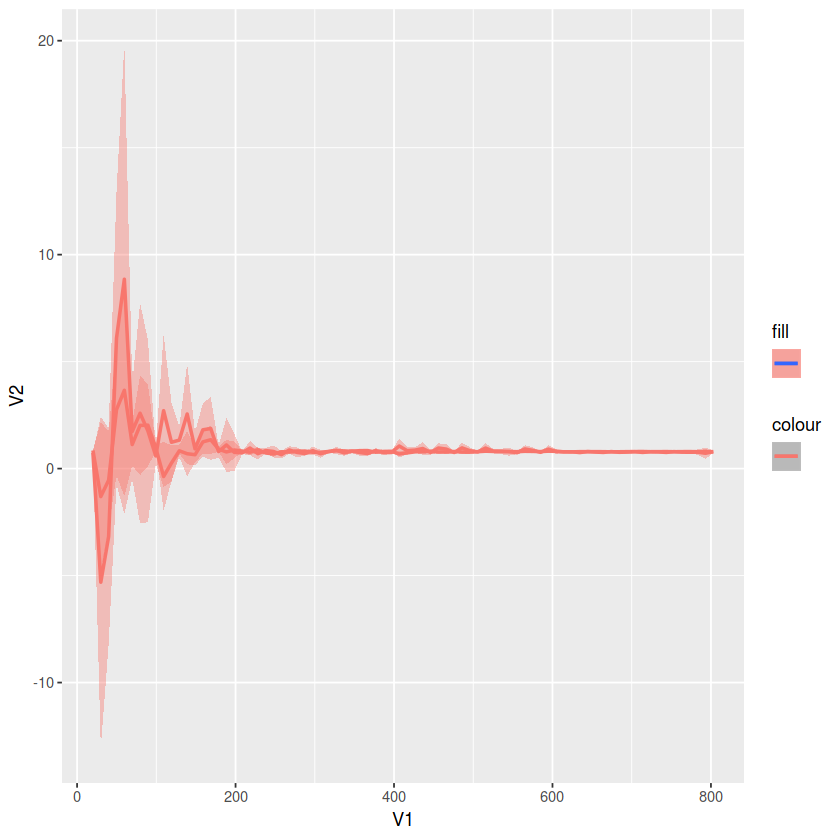

[1] 1
[1] 0.8418079


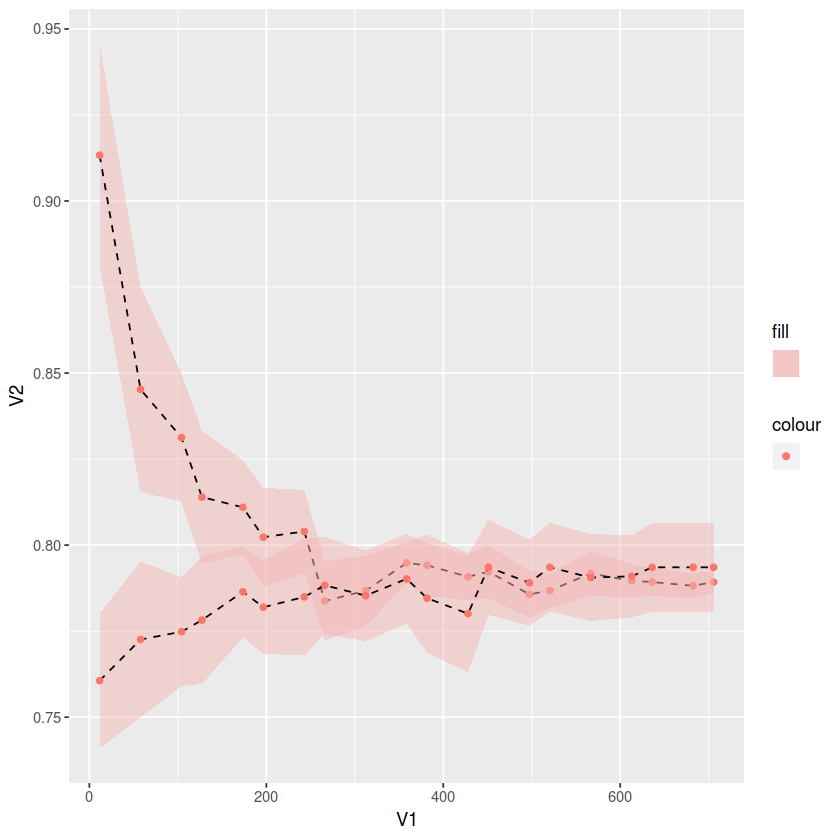

In [95]:
features <- c("Pclass", "Title", "Fare.log", "Age.simple")

p <- learning_curve$plot.advanced(train, test=0.2, target="SurvivedF", features = features, 
                             model_fun = svm.linear.model_fun, steps = 20, variations = 15)
print(p)